# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
!pip -q install '/home/workspace/python'

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.8 which is incompatible.


In [2]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [3]:
#env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")
#env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")
env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis.x86")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
#from buffer import ReplayBuffer
from Memory import ReplayMemory
import core as core
import torch
import numpy as np
from tensorboardX import SummaryWriter
import os
from utilities import transpose_list, transpose_to_tensor
from collections import deque
from copy import deepcopy
import itertools
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [7]:
actor_critic=core.MLPActorCritic
ac_kwargs=dict()
seed=0
steps_per_epoch=4000
epochs=100
replay_size=int(1e5)
gamma=0.995
polyak=0.995
lr=1e-3
alpha=0.2
batchsize = 128
start_steps=2000
update_after=1000
update_every=50
n_updates = 1
num_test_episodes=10
max_ep_len=1000
#logger_kwargs=dict()
save_freq=1

log_path = os.getcwd()+"/log"
model_dir= os.getcwd()+"/model_dir"

os.makedirs(model_dir, exist_ok=True)

In [8]:
torch.manual_seed(seed)
np.random.seed(seed)

obs_dim = state_size
act_dim = action_size
act_limit = 1.0 # Action limit for clamping: critically, assumes all dimensions share the same bound!
ac_kwargs = dict(hidden_sizes=(512, 256))

In [9]:
# Create actor-critic module and target networks

ac_1 = actor_critic(obs_dim, act_dim, act_limit, num_agents, **ac_kwargs).to(device)
ac_1_targ = deepcopy(ac_1)
ac_2 = actor_critic(obs_dim, act_dim, act_limit, num_agents, **ac_kwargs).to(device)
ac_2_targ = deepcopy(ac_2)
ac = [ac_1, ac_2]
ac_targ = [ac_1_targ, ac_2_targ]

In [10]:
# Freeze target networks with respect to optimizers (only update via polyak averaging)
for m in ac_targ:
    for p in m.parameters():
        p.requires_grad = False

# List of parameters for both Q-networks (save this for convenience)
q_params = [itertools.chain(m.q1.parameters(), m.q2.parameters()) for m in ac]

# Set up optimizers for policy and q-function
pi_optimizer = [torch.optim.Adam(m.pi.parameters(), lr=lr) for m in ac]
q_optimizer = []
for i in range(num_agents):
    q_optimizer.append(torch.optim.Adam(q_params[i], lr=lr))

In [11]:
# Experience buffer
buffer = ReplayMemory(replay_size)

In [12]:
# Count variables (protip: try to get a feel for how different size networks behave!)
var_counts = []
for m in ac:
    var_counts.append(tuple(core.count_vars(module) for module in [m.pi, m.q1, m.q2]))
var_counts

[(145156, 158721, 158721), (145156, 158721, 158721)]

In [13]:
# Set up function for computing SAC Q-losses
def compute_loss_q(data, agent_num):
    
    # helper function to re-order inputs from perspective of the agent
    def rotate(inputs):
        return inputs[agent_num:] + inputs[:agent_num]
    
    #o, a, r, o2, d = data['obs'], data['act'], data['rew'], data['obs2'], data['done']
    o, a, r, o2, d = map(transpose_to_tensor, data) 
    
    o_full = torch.cat(rotate(o), dim=1).to(device)
    o2_full = torch.cat(rotate(o2), dim=1).to(device)
    a_full = torch.cat(rotate(a), dim=1).to(device)

    agent = ac[agent_num]
    agent_targ = ac_targ[agent_num]
    
    q1 = agent.q1(o_full.clone(),a_full.clone())
    q2 = agent.q2(o_full.clone(),a_full.clone())

    # Bellman backup for Q functions
    with torch.no_grad():
        # Target actions come from *current* policy
        a2, logp_a2 = [], []
        for obs, m in zip(o2, ac):
            a2_m, logp_a2_m = m.pi(obs.to(device))
            a2.append(a2_m)
            logp_a2.append(logp_a2_m)
            
        a2_full = torch.cat(rotate(a2), dim=1).to(device)

        # Target Q-values
        q1_pi_targ = agent_targ.q1(o2_full.clone(), a2_full.clone())
        q2_pi_targ = agent_targ.q2(o2_full.clone(), a2_full.clone())
        q_pi_targ = torch.min(q1_pi_targ, q2_pi_targ)
        backup = (r[agent_num] + gamma * (1 - d[agent_num])).to(device) * (q_pi_targ - alpha * logp_a2[agent_num])

    # MSE loss against Bellman backup
    loss_q1 = ((q1 - backup.clone())**2).mean()
    loss_q2 = ((q2 - backup.clone())**2).mean()
    loss_q = loss_q1 + loss_q2

    # Useful info for logging
    q_info = dict(Q1Vals=q1.cpu().detach().numpy(),
                  Q2Vals=q2.cpu().detach().numpy())

    return loss_q, q_info

In [14]:
def compute_loss_pi(data, agent_num):
    
    def rotate(inputs):
        return inputs[agent_num:] + inputs[:agent_num]
    
    o, a, r, o2, d = map(transpose_to_tensor, data) 
    o_full = torch.cat(rotate(o), dim=1).to(device)
    
    pi, logp_pi = [], []
    for obs, m in zip(o, ac):
        pi_m, logp_pi_m = m.pi(obs.to(device))
        pi.append(pi_m)
        logp_pi.append(logp_pi_m)

    pi_full = torch.cat(rotate(pi), dim=1).to(device)
    
    agent = ac[agent_num]
    
    q1_pi = agent.q1(o_full.clone(), pi_full.clone())
    q2_pi = agent.q2(o_full.clone(), pi_full.clone())
    q_pi = torch.min(q1_pi, q2_pi)

    # Entropy-regularized policy loss
    loss_pi = (alpha * logp_pi[agent_num] - q_pi).mean()

    # Useful info for logging
    pi_info = dict(LogPi=logp_pi[agent_num].cpu().detach().numpy())

    return loss_pi, pi_info

In [15]:
def get_action(obs_all_agents, deterministic=False):
    actions = [agent.act(torch.tensor(o, dtype=torch.float32).to(device), deterministic) 
               for agent, o in zip(ac, obs_all_agents)]
    return actions

def get_random_action():
    actions = [np.random.rand(2).astype(np.float32) for _ in range(num_agents)]
    return actions

In [16]:
def update(data, agent_num):
    # First run one gradient descent step for Q1 and Q2
    q_optimizer[agent_num].zero_grad()
    loss_q, q_info = compute_loss_q(data, agent_num)
    loss_q.backward()
    q_optimizer[agent_num].step()

    # Record things
    #logger.store(LossQ=loss_q.item(), **q_info)

    # Freeze Q-networks so you don't waste computational effort 
    # computing gradients for them during the policy learning step.
    for p in q_params[agent_num]:
        p.requires_grad = False

    # Next run one gradient descent step for pi.
    pi_optimizer[agent_num].zero_grad()
    loss_pi, pi_info = compute_loss_pi(data, agent_num)
    loss_pi.backward()
    pi_optimizer[agent_num].step()

    # Unfreeze Q-networks so you can optimize it at next DDPG step.
    for p in q_params[agent_num]:
        p.requires_grad = True

    # Record things
    #logger.store(LossPi=loss_pi.item(), **pi_info)

    # Finally, update target networks by polyak averaging.
    with torch.no_grad():
        for p, p_targ in zip(ac[agent_num].parameters(), ac_targ[agent_num].parameters()):
            # NB: We use an in-place operations "mul_", "add_" to update target
            # params, as opposed to "mul" and "add", which would make new tensors.
            p_targ.data.mul_(polyak)
            p_targ.data.add_((1 - polyak) * p.data)

In [17]:
number_of_episodes = 60000
save_interval = 1000
episode_per_update = 2

In [18]:
from workspace_utils import keep_awake

number_of_episodes = 60000
save_interval = 1000
episode_per_update = 2

#agent0_reward = []
#agent1_reward = []

scores_deque = deque(maxlen=100)
ent_len_deque = deque(maxlen=100)
scores = []                                                         
average_scores = []
t = 0
ent_len = 0

for episode in keep_awake(range(1, number_of_episodes+1)):

    reward_this_episode = np.zeros(num_agents)
    env_info = env.reset(train_mode=True)[brain_name]
    obs = env_info.vector_observations

    #for calculating rewards for this particular episode - addition of all time steps

    # save info or not
    save_info = ((episode) % save_interval == 0 or episode==number_of_episodes-1)

    while True:
        
        if t > start_steps:
            actions = get_random_action()
        else:
            actions = get_action(obs) # return list of numpy arrays
        actions = np.stack(actions)

        # step forward one frame
        env_info = env.step(actions)[brain_name]
        next_obs = env_info.vector_observations            # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
 
        # add data to buffer
        transition = (obs, actions, rewards, next_obs, dones)
        buffer.push(*transition)

        reward_this_episode += rewards
        ent_len += 1
        t += 1
        '''
        if t >= update_after and t % update_every == 0:
            for _ in range(update_every * n_updates):  # train for ent_len for each episode
                #samples = buffer.sample(batchsize)
                for a_i in range(num_agents):
                    samples = buffer.sample(batchsize)
                    update(samples, a_i)
        '''       
        obs = next_obs
        
        if np.any(dones):
            break
    
    # calcualte episode length
    ent_len_deque.append(ent_len)
    ent_len = 0
    # calcualte socres
    score = np.max(reward_this_episode)
    scores.append(score)
    scores_deque.append(score)
    average_score = np.mean(scores_deque)
    average_scores.append(average_score)
    episode_with_scores = np.sum(np.where(scores_deque, 1, 0))
    
    # update once after every episode_per_update
    if len(buffer) > batchsize and episode % episode_per_update == 0:
        for _ in range(t):  # train for ent_len for each episode
            #samples = buffer.sample(batchsize)
            for a_i in range(num_agents):
                samples = buffer.sample(batchsize)
                update(samples, a_i)
        t = 0
  
    print('\rEpisode {}\tAverage Score: {:.4f}\tScore: {:.4f}\tAvg Ep Length: {:.1f}\tEp with Scores: {}'.format(episode, average_score, score, np.mean(ent_len_deque), episode_with_scores), end="")
    if episode % 100 == 0:
        print('\rEpisode {}\tAverage score: {:.4f}'.format(episode , average_score))
    if average_score >= 0.5:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(episode, average_score))
        break

    #saving model
    save_dict_list =[]
    if save_info:
        for i in range(num_agents):

            save_dict = {'pi_params' : ac[i].pi.state_dict(),
                         'pi_optim_params': pi_optimizer[i].state_dict(),
                         'q1_params' : ac[i].q1.state_dict(),
                         'q2_params' : ac[i].q2.state_dict(),
                         'q_optim_params' : q_optimizer[i].state_dict()}
            save_dict_list.append(save_dict)
            
        torch.save(save_dict_list, os.path.join(model_dir, 'episode-{}.pt'.format(episode)))


Episode 100	Average score: 0.0124	Score: 0.0000	Avg Ep Length: 17.9	Ep with Scores: 13
Episode 200	Average score: 0.0145	Score: 0.0000	Avg Ep Length: 17.4	Ep with Scores: 15
Episode 300	Average score: 0.0220	Score: 0.0000	Avg Ep Length: 19.0	Ep with Scores: 23
Episode 400	Average score: 0.0270	Score: 0.0000	Avg Ep Length: 19.8	Ep with Scores: 27
Episode 500	Average score: 0.0462	Score: 0.0000	Avg Ep Length: 24.7	Ep with Scores: 45
Episode 600	Average score: 0.0574	Score: 0.1000	Avg Ep Length: 26.6	Ep with Scores: 57
Episode 700	Average score: 0.0735	Score: 0.1000	Avg Ep Length: 32.5	Ep with Scores: 71
Episode 800	Average score: 0.0884	Score: 0.1000	Avg Ep Length: 35.8	Ep with Scores: 84
Episode 900	Average score: 0.0946	Score: 0.1000	Avg Ep Length: 39.5	Ep with Scores: 85
Episode 1000	Average score: 0.1273	Score: 0.1000	Avg Ep Length: 51.6	Ep with Scores: 91
Episode 1100	Average score: 0.1199	Score: 0.1000	Avg Ep Length: 49.8	Ep with Scores: 89
Episode 1200	Average score: 0.1493	Score:

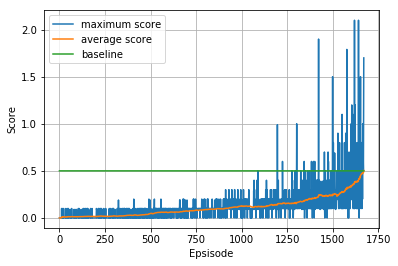

In [19]:
baseline = 0.5 * np.ones(len(scores))

fig, ax = plt.subplots()
ax.plot(scores, label='maximum score')
ax.plot(average_scores, label='average score')
ax.plot(baseline, label='baseline')
ax.set(ylabel='Score', xlabel='Epsisode')
ax.legend()
ax.grid()
plt.show()

In [25]:
#save final model
save_dict_list =[]
for i in range(num_agents):

    save_dict = {'pi_params' : ac[i].pi.state_dict(),
                 'pi_optim_params': pi_optimizer[i].state_dict(),
                 'q1_params' : ac[i].q1.state_dict(),
                 'q2_params' : ac[i].q2.state_dict(),
                 'q_optim_params' : q_optimizer[i].state_dict()}
    save_dict_list.append(save_dict)

torch.save(save_dict_list, os.path.join(model_dir, 'episode-{}.pt'.format('solved-0.5')))

In [21]:
def test_agent():
    for j in range(num_test_episodes):
        
        reward_this_episode = np.zeros(num_agents)
        env_info = env.reset(train_mode=True)[brain_name]
        obs = env_info.vector_observations
        ep_len = 0
        
        while True:
            actions = get_action(obs, deterministic=True) # return list of numpy arrays
            actions = np.stack(actions)

            # step forward one frame
            env_info = env.step(actions)[brain_name]
            obs = env_info.vector_observations            # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done  
            ep_len += 1
            reward_this_episode += rewards
            
            if np.any(dones):
                break
                
        print('\rEpisode {}\tScore 0: {:.2f}\tScore 1: {:.2f}\tLength: {}'.
              format(j, reward_this_episode[0], reward_this_episode[1], ep_len))

In [22]:
test_agent()

Episode 0	Score 0: 2.60	Score 1: 2.60	Length: 1001
Episode 1	Score 0: 2.60	Score 1: 2.70	Length: 1001
Episode 2	Score 0: 2.70	Score 1: 2.60	Length: 1001
Episode 3	Score 0: 2.60	Score 1: 2.60	Length: 1001
Episode 4	Score 0: 2.60	Score 1: 2.70	Length: 1001
Episode 5	Score 0: 2.70	Score 1: 2.60	Length: 1001
Episode 6	Score 0: 2.60	Score 1: 2.60	Length: 1001
Episode 7	Score 0: 2.60	Score 1: 2.70	Length: 1001
Episode 8	Score 0: 2.70	Score 1: 2.60	Length: 1001
Episode 9	Score 0: 2.60	Score 1: 2.60	Length: 1001


In [26]:
# routine to load saved model from disk

from utilities import hard_update
model_name = 'episode-{}.pt'.format('solved-0.5')

checkpoint = torch.load(os.path.join(model_dir, model_name))

for i in range(2):

    ac[i].pi.load_state_dict(checkpoint[i]['pi_params'])
    pi_optimizer[i].load_state_dict(checkpoint[i]['pi_optim_params'])
    ac[i].q1.load_state_dict(checkpoint[i]['q1_params'])
    ac[i].q2.load_state_dict(checkpoint[i]['q2_params'])
    q_optimizer[i].load_state_dict(checkpoint[i]['q_optim_params'])
    
    hard_update(ac_targ[i].pi, ac[i].pi)
    hard_update(ac_targ[i].q1, ac[i].q1)
    hard_update(ac_targ[i].q2, ac[i].q2)

In [27]:
for episode in keep_awake(range(1, number_of_episodes+1)):

    reward_this_episode = np.zeros(num_agents)
    env_info = env.reset(train_mode=True)[brain_name]
    obs = env_info.vector_observations

    #for calculating rewards for this particular episode - addition of all time steps

    # save info or not
    save_info = ((episode) % save_interval == 0 or episode==number_of_episodes-1)

    while True:
        
        if t > start_steps:
            actions = get_random_action()
        else:
            actions = get_action(obs) # return list of numpy arrays
        actions = np.stack(actions)

        # step forward one frame
        env_info = env.step(actions)[brain_name]
        next_obs = env_info.vector_observations            # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
 
        # add data to buffer
        transition = (obs, actions, rewards, next_obs, dones)
        buffer.push(*transition)

        reward_this_episode += rewards
        ent_len += 1
        t += 1
        '''
        if t >= update_after and t % update_every == 0:
            for _ in range(update_every * n_updates):  # train for ent_len for each episode
                #samples = buffer.sample(batchsize)
                for a_i in range(num_agents):
                    samples = buffer.sample(batchsize)
                    update(samples, a_i)
        '''       
        obs = next_obs
        
        if np.any(dones):
            break
    
    # calcualte episode length
    ent_len_deque.append(ent_len)
    ent_len = 0
    # calcualte socres
    score = np.max(reward_this_episode)
    scores.append(score)
    scores_deque.append(score)
    average_score = np.mean(scores_deque)
    average_scores.append(average_score)
    episode_with_scores = np.sum(np.where(scores_deque, 1, 0))
    
    # update once after every episode_per_update
    if len(buffer) > batchsize and episode % episode_per_update == 0:
        for _ in range(t):  # train for ent_len for each episode
            #samples = buffer.sample(batchsize)
            for a_i in range(num_agents):
                samples = buffer.sample(batchsize)
                update(samples, a_i)
        t = 0
  
    print('\rEpisode {}\tAverage Score: {:.4f}\tScore: {:.4f}\tAvg Ep Length: {:.1f}\tEp with Scores: {}'.format(episode, average_score, score, np.mean(ent_len_deque), episode_with_scores), end="")
    if episode % 100 == 0:
        print('\rEpisode {}\tAverage score: {:.4f}'.format(episode , average_score))
    if average_score >= 2.0:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(episode, average_score))
        break

    #saving model
    save_dict_list =[]
    if save_info:
        for i in range(num_agents):

            save_dict = {'pi_params' : ac[i].pi.state_dict(),
                         'pi_optim_params': pi_optimizer[i].state_dict(),
                         'q1_params' : ac[i].q1.state_dict(),
                         'q2_params' : ac[i].q2.state_dict(),
                         'q_optim_params' : q_optimizer[i].state_dict()}
            save_dict_list.append(save_dict)
            
        torch.save(save_dict_list, os.path.join(model_dir, 'episode-{}.pt'.format(episode)))


Episode 100	Average score: 1.7228	Score: 2.2000	Avg Ep Length: 655.1	Ep with Scores: 99
Episode 121	Average Score: 2.0099	Score: 2.2000	Avg Ep Length: 763.5	Ep with Scores: 99
Environment solved in 121 episodes!	Average Score: 2.0099


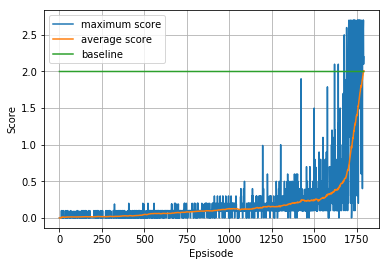

In [28]:
baseline = 2.0 * np.ones(len(scores))

fig, ax = plt.subplots()
ax.plot(scores, label='maximum score')
ax.plot(average_scores, label='average score')
ax.plot(baseline, label='baseline')
ax.set(ylabel='Score', xlabel='Epsisode')
ax.legend()
ax.grid()
plt.show()

In [29]:
test_agent()

Episode 0	Score 0: 2.60	Score 1: 2.60	Length: 1001
Episode 1	Score 0: 2.70	Score 1: 2.60	Length: 1001
Episode 2	Score 0: 2.60	Score 1: 2.60	Length: 1001
Episode 3	Score 0: 2.60	Score 1: 2.70	Length: 1001
Episode 4	Score 0: 2.70	Score 1: 2.60	Length: 1001
Episode 5	Score 0: 2.60	Score 1: 2.60	Length: 1001
Episode 6	Score 0: 2.60	Score 1: 2.70	Length: 1001
Episode 7	Score 0: 2.70	Score 1: 2.60	Length: 1001
Episode 8	Score 0: 2.60	Score 1: 2.60	Length: 1001
Episode 9	Score 0: 2.60	Score 1: 2.70	Length: 1001


In [30]:
#save final model
save_dict_list =[]

for i in range(num_agents):

    save_dict = {'pi_params' : ac[i].pi.state_dict(),
                 'pi_optim_params': pi_optimizer[i].state_dict(),
                 'q1_params' : ac[i].q1.state_dict(),
                 'q2_params' : ac[i].q2.state_dict(),
                 'q_optim_params' : q_optimizer[i].state_dict()}
    save_dict_list.append(save_dict)

torch.save(save_dict_list, os.path.join(model_dir, 'episode-{}.pt'.format('solved-2.0')))